Synchronization
===============

In this tutorial we will demonstrate how to synchronize two Qblox instruments using the SYNQ technology (see section
[Synchronization](https://qblox-qblox-instruments.readthedocs-hosted.com/en/master/cluster/synchronization.html)).
For this tutorial we will use one QCM and one QRM and we will be acquiring waveforms sequenced by the QCM using the QRM.
By synchronizing the two instruments using the SYNQ technology, timing the acquisition of the waveforms becomes trivial.

The Cluster QCM and QRM are internally connected for SYNQ capability and therefore no new connections need to be made if one is using a Cluster.
To run the tutorial, we connect $\text{O}^{[1-2]}$ of the QCM to $\text{I}^{[1-2]}$ of the QRM respectively.

To run this tutorial please make sure you have installed and enabled ipywidgets:
```
pip install ipywidgets
jupyter nbextension enable --py widgetsnbextension
```

Setup
-----

First, we are going to import the required packages and connect to the instrument.

In [1]:
# Import ipython widgets
import contextlib
import json
import math

import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np

# Set up the environment.
import scipy.signal
from IPython.display import display
from qcodes import Instrument

from qblox_instruments import Cluster, PlugAndPlay

### Scan For Clusters

We scan for the available devices connected via ethernet using the Plug & Play functionality of the Qblox Instruments package (see [Plug & Play](https://qblox-qblox-instruments.readthedocs-hosted.com/en/master/api_reference/tools.html#api-pnp) for more info).

In [2]:
!qblox-pnp list

Devices:
 - 10.10.200.13: cluster_mm 0.6.2 with name "QSE_1" and serial number 00015_2321_005
 - 10.10.200.42: cluster_mm 0.6.2 with name "QAE_1" and serial number 00015_2320_004
 - 10.10.200.43: cluster_mm 0.6.2 with name "QAE_2" and serial number 00015_2206_003
 - 10.10.200.50: cluster_mm 0.6.1 with name "dd0" and serial number 00015_2219_003
 - 10.10.200.53: cluster_mm 0.6.1 with name "dd1" and serial number 00015_2320_003
 - 10.10.200.70: cluster_mm 0.6.1 with name "cluster-mm" and serial number 123-456-789


In [3]:
cluster_ip = "10.10.200.42"
cluster_name = "cluster0"

### Connect to Cluster

We now make a connection with the Cluster.

In [4]:
from qblox_instruments import Cluster, ClusterType

try:  # Close the chosen QCodes instrument to prevent name clash
    Cluster.find_instrument(cluster_name).close()
except KeyError:
    pass

cluster = Cluster(
    name=cluster_name,
    identifier=cluster_ip,
    dummy_cfg={
        2: ClusterType.CLUSTER_QCM,
        4: ClusterType.CLUSTER_QRM,
        6: ClusterType.CLUSTER_QCM_RF,
        8: ClusterType.CLUSTER_QRM_RF,
    }
    if cluster_ip is None
    else None,
)

#### Get connected modules

In [5]:
def get_connected_modules(cluster, filter_fn=None):
    def checked_filter_fn(mod):
        if filter_fn is not None:
            return filter_fn(mod)
        return True

    return {
        mod.slot_idx: mod for mod in cluster.modules if mod.present() and checked_filter_fn(mod)
    }

In [6]:
# QRM baseband modules
readout_modules = get_connected_modules(cluster, lambda mod: mod.is_qrm_type and not mod.is_rf_type)
readout_modules

{4: <QcmQrm: cluster0_module4 of Cluster: cluster0>}

In [7]:
readout_module = readout_modules[4]

In [8]:
# QCM baseband modules
control_modules = get_connected_modules(
    cluster, lambda mod: not mod.is_qrm_type and not mod.is_rf_type
)
control_modules

{2: <QcmQrm: cluster0_module2 of Cluster: cluster0>}

In [9]:
control_module = control_modules[2]

### Reset the Cluster

We reset the Cluster to enter a well-defined state. Note that resetting will clear all stored parameters, so resetting between experiments is usually not desirable.

In [10]:
cluster.reset()
print(cluster.get_system_state())

Status: OKAY, Flags: NONE, Slot flags: NONE


Generate waveforms<a id='gen_wf'></a>
------------------

Next, we need to create the waveforms for the sequence.

In [11]:
# Waveform parameters
waveform_length = 120  # nanoseconds

# Waveform dictionary (data will hold the samples and index will be used to select the waveforms in the instrument).
waveforms = {
    "gaussian": {
        "data": scipy.signal.windows.gaussian(waveform_length, std=0.12 * waveform_length).tolist(),
        "index": 0,
    },
    "sine": {
        "data": [math.sin((2 * math.pi / waveform_length) * i) for i in range(0, waveform_length)],
        "index": 1,
    },
}

Let's plot the waveforms to see what we have created.

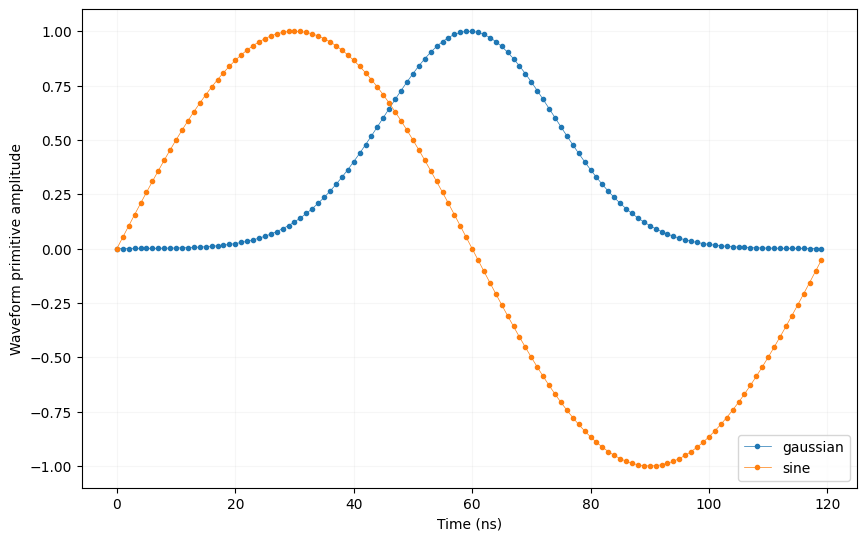

In [12]:
time = np.arange(0, max(map(lambda d: len(d["data"]), waveforms.values())), 1)
fig, ax = plt.subplots(1, 1, figsize=(10, 10 / 1.61))

for wf, d in waveforms.items():
    ax.plot(time[: len(d["data"])], d["data"], ".-", linewidth=0.5, label=wf)

ax.legend(loc=4)
ax.grid(alpha=1 / 10)
ax.set_ylabel("Waveform primitive amplitude")
ax.set_xlabel("Time (ns)")

plt.draw()
plt.show()

Specify acquisitions
--------------------

We also need to specify the acquisitions so that the instrument can allocate the required memory for it's acquisition list. In this case we will create one acquisition specification that creates a single bin. However, we will not be using the bin in this tutorial.

In [13]:
# Acquisitions
acquisitions = {"measurement": {"num_bins": 1, "index": 0}}

Create Q1ASM programs
---------------------

Now that we have the waveforms and acquisition specifications for the sequence, we need a simple Q1ASM program that sequences the waveforms in the QCM and
acquires the waveforms in the QRM.

In [14]:
# QCM sequence program.
qcm_seq_prog = """
wait_sync 4         #Synchronize sequencers over multiple instruments.
play      0,1,16384 #Play waveforms and wait remaining duration of scope acquisition.
stop                #Stop.
"""

# QRM sequence program.
qrm_seq_prog = """
wait_sync 4         #Synchronize sequencers over multiple instruments.
acquire   0,0,16384 #Acquire waveforms and wait remaining duration of scope acquisition.
stop                #Stop.
"""

Upload sequences
----------------

Now that we have the waveforms and Q1ASM programs, we can combine them in the sequences stored in JSON files.

In [15]:
# Add QCM sequence to single dictionary and write to JSON file.
sequence = {
    "waveforms": waveforms,
    "weights": {},
    "acquisitions": acquisitions,
    "program": qcm_seq_prog,
}
with open("qcm_sequence.json", "w", encoding="utf-8") as file:
    json.dump(sequence, file, indent=4)
    file.close()

# Add QRM sequence to single dictionary and write to JSON file.
sequence = {
    "waveforms": waveforms,
    "weights": {},
    "acquisitions": acquisitions,
    "program": qrm_seq_prog,
}
with open("qrm_sequence.json", "w", encoding="utf-8") as file:
    json.dump(sequence, file, indent=4)
    file.close()

Let's write the JSON file to the instruments. We will use sequencer 0 of both QCM and QRM, which will drive outputs $\text{O}^{[1-2]}$
of the QCM and acquire on inputs $\text{I}^{[1-2]}$ of the QRM.

In [16]:
# Upload waveforms and programs to QCM.
control_module.sequencer0.sequence("qcm_sequence.json")

# Upload waveforms and programs to QRM.
readout_module.sequencer0.sequence("qrm_sequence.json")

Play sequences
--------------

The sequence has been uploaded to the instruments. Now we need to configure the sequencers of both the QCM and QRM to use the `wait_sync` instruction
to synchronize and we need to configure the sequencer of the QRM to trigger the acquisition with the `acquire` instruction.
Furthermore we also need to attenuate the QCM's outputs to 40% to be able to capture the full range of the waveforms on the QRM's inputs.

$\text{Attenuation}={Input}/{Output}={2V}/{5V}={0.4}$

In [17]:
# Configure the sequencer of the QCM.
control_module.sequencer0.sync_en(True)
control_module.sequencer0.gain_awg_path0(0.35)  # Adding a bit of margin to the 0.4
control_module.sequencer0.gain_awg_path1(0.35)

# Map sequencer of the QCM to specific outputs (but first disable all sequencer connections)
control_module.disconnect_outputs()
readout_module.disconnect_outputs()
readout_module.disconnect_inputs()

control_module.sequencer0.connect_sequencer("out0_1")

# Also map inputs
readout_module.sequencer0.connect_sequencer("in0_1")

# Configure the scope acquisition of the QRM.
readout_module.scope_acq_sequencer_select(0)
readout_module.scope_acq_trigger_mode_path0("sequencer")
readout_module.scope_acq_trigger_mode_path1("sequencer")

# Configure the sequencer of the QRM.
readout_module.sequencer0.sync_en(True)

Now let's start the sequences.

In [18]:
# Arm and start sequencer of the QCM (only sequencer 0).
control_module.arm_sequencer(0)
control_module.start_sequencer()

# Print status of sequencer of the QCM.
print("QCM status:")
print(control_module.get_sequencer_state(0))
print()

# Arm and start sequencer of the QRM (only sequencer 0).
readout_module.arm_sequencer(0)
readout_module.start_sequencer()

# Print status of sequencer of the QRM.
print("QRM status:")
print(readout_module.get_sequencer_state(0))

QCM status:
Status: Q1_STOPPED, Flags: NONE

QRM status:
Status: STOPPED, Flags: ACQ_SCOPE_DONE_PATH_0, ACQ_SCOPE_DONE_PATH_1, ACQ_BINNING_DONE


Retrieve acquisition
--------------------

The waveforms have now been sequenced on the outputs and acquired on the inputs by both instruments. And as you might have noticed, timing these operations was simplified
significantly by the SYNQ technology. Lets retrieve the resulting data, but first let's make sure the sequencers have finished.

In [19]:
# Wait for the QCM sequencer to stop with a timeout period of one minute.
control_module.get_sequencer_state(0, 1)

# Wait for the QRM acquisition to finish with a timeout period of one minute.
readout_module.get_acquisition_state(0, 1)

# Move acquisition data from temporary memory to acquisition list.
readout_module.store_scope_acquisition(0, "measurement")

# Get acquisition list from instrument.
acq = readout_module.get_acquisitions(0)

Let's plot the result.

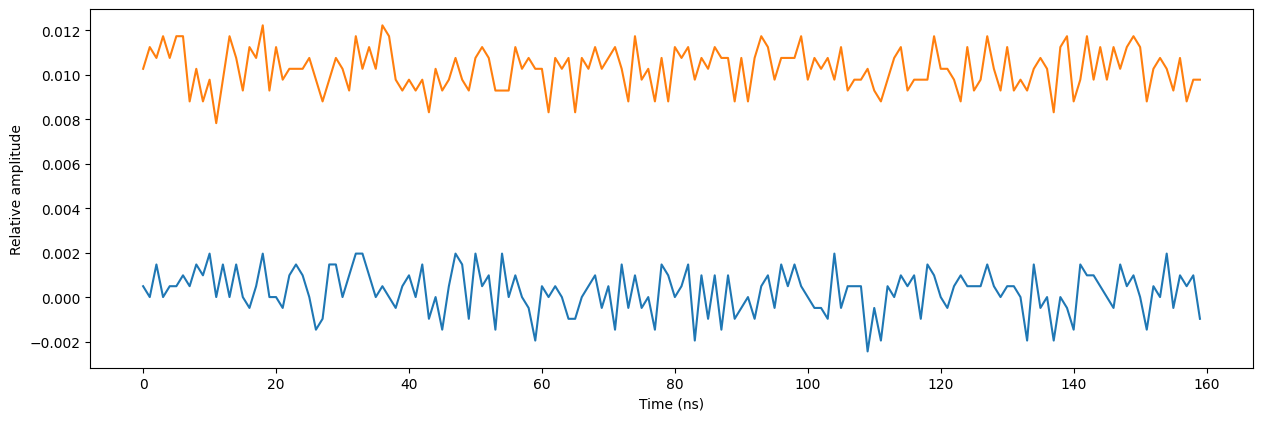

In [20]:
# Plot acquired signal on both inputs.
fig, ax = plt.subplots(1, 1, figsize=(15, 15 / 2 / 1.61))
ax.plot(acq["measurement"]["acquisition"]["scope"]["path0"]["data"][130:290])
ax.plot(acq["measurement"]["acquisition"]["scope"]["path1"]["data"][130:290])
ax.set_xlabel("Time (ns)")
ax.set_ylabel("Relative amplitude")
plt.show()

Stop
----

Finally, let's stop the sequencers if they haven't already and close the instrument connection. One can also display a detailed snapshot containing the instrument parameters before
closing the connection by uncommenting the corresponding lines.

In [21]:
# Stop sequencers.
control_module.stop_sequencer()
readout_module.stop_sequencer()

# Print status of sequencers.
print("QCM:")
print(control_module.get_sequencer_state(0))
print()

print("QRM:")
print(readout_module.get_sequencer_state(0))
print()

# Uncomment the following to print an overview of the instrument parameters.
# Print an overview of instrument parameters.
# print("QCM snapshot:")
# qcm.print_readable_snapshot(update=True)
# print()

# print("QRM snapshot:")
# readout_module.print_readable_snapshot(update=True)

# Reset the cluster
cluster.reset()
print(cluster.get_system_state())

QCM:
Status: STOPPED, Flags: FORCED_STOP

QRM:
Status: STOPPED, Flags: FORCED_STOP, ACQ_SCOPE_DONE_PATH_0, ACQ_SCOPE_DONE_PATH_1, ACQ_BINNING_DONE



Status: OKAY, Flags: NONE, Slot flags: NONE
